In [25]:
import numpy as np
import os
import matplotlib.pyplot as plt
from hhdc.canopy_plots import create_chm

cubes = os.listdir("/home/andres/MassiveDataset/dataset_high")
cubes = ["/home/andres/MassiveDataset/dataset_high/" + c for c in cubes if c.endswith('.npz')]

cubes = os.listdir("cubes/SERC/2016-07")
cubes = ["cubes/SERC/2016-07/" + c for c in cubes if c.endswith('.npz')]

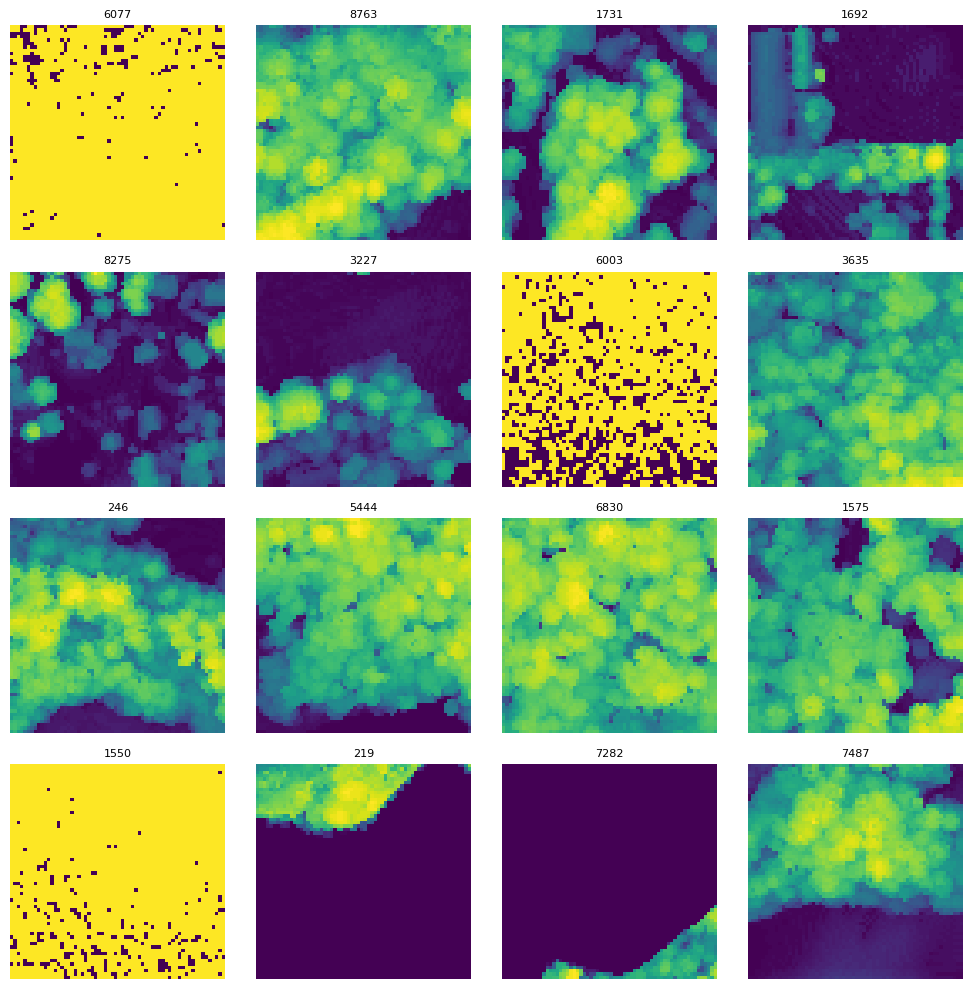

In [28]:
import random

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

random_indices = random.sample(range(len(cubes)), 16)

for idx, ax in enumerate(axes):
    cube_path = cubes[random_indices[idx]]
    cube_data = np.load(cube_path)['cube']
    chm = create_chm(np.swapaxes(cube_data, 0, -1))[0]
    
    ax.imshow(chm)
    ax.set_title(f"{random_indices[idx]}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


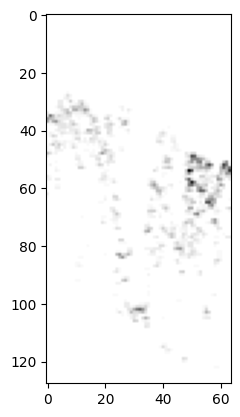

In [31]:
my_cube = np.swapaxes(np.load(cubes[10])['cube'], 0, -1)
# my_cube = my_cube / np.max(my_cube,axis=0)

plt.imshow(my_cube[::-1,:,0], cmap='gray_r')

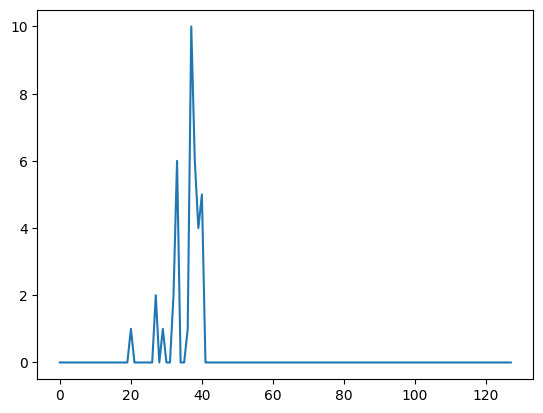

In [32]:
plt.plot(my_cube[:,34,29])

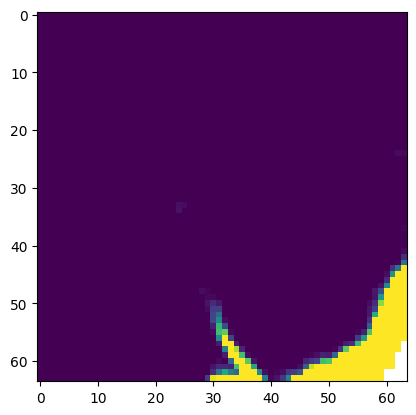

In [16]:
plt.imshow(my_cube[0][:,:])